import packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

#is_cuda = torch.cuda.is_available()
#device = torch.device('cuda' if is_cuda else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

## Data Manipulation

In [17]:
import torchvision.transforms as transforms
compose = transforms.Compose([
    transforms.CenterCrop((200,330)),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
data_dir = '/content/drive/MyDrive/dataset_doeun_0825/spec/'
dataset = torchvision.datasets.ImageFolder(data_dir,transform=compose)

In [8]:
len(dataset)

1190

train / test 나누기: test set는 200개로 CV 할 때마다 성능 검사

In [19]:
from torch.utils.data import random_split
seed_everything(42)
train_data, test_data = random_split(dataset,[990,200])

In [20]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle =True)

5-fold로 데이터 나누기

In [21]:
from sklearn.model_selection import KFold
from torch.utils import data

seed_everything(12)
folds = KFold(n_splits=5,shuffle=True)
train = []
valid = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data)):
    dataset_train = data.Subset(train_data, train_idx)
    dataset_valid = data.Subset(train_data, valid_idx)
    trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle =True)
    train.append(trainloader)
    validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=10, shuffle=True)
    valid.append(validloader)

In [12]:
for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data)):
  print(i_fold)
  print('train',valid_idx)

0
train [  4   7  13  15  16  20  34  38  43  54  61  75  77  89  90  97  98 101
 111 115 116 117 120 122 131 133 153 161 163 164 167 175 177 178 183 187
 190 191 194 196 206 207 213 216 218 221 226 229 242 248 249 252 268 270
 274 277 278 282 283 289 296 301 303 313 321 326 330 338 343 344 347 350
 351 352 353 355 362 363 369 371 377 379 381 388 390 391 401 404 405 408
 410 415 416 421 431 433 440 459 465 467 468 471 473 474 475 476 483 492
 500 501 502 508 519 525 535 543 545 552 570 571 579 581 592 594 596 605
 606 613 627 632 633 639 647 649 661 665 667 669 671 674 676 677 691 694
 700 710 721 727 730 737 740 744 760 776 781 782 786 793 798 803 809 810
 813 815 824 825 826 829 835 838 843 850 858 861 865 867 869 874 897 911
 915 924 928 932 934 942 947 948 950 952 953 954 955 958 966 982 984 988]
1
train [  0   2   3   5   8  10  27  28  44  45  51  59  66  69  74  81  84  85
  88  92  93 109 124 129 130 132 137 143 155 157 160 165 166 169 173 188
 204 208 214 220 225 227 231 245 2

torch.Size([10, 3, 224, 224])
torch.Size([3, 224, 224])


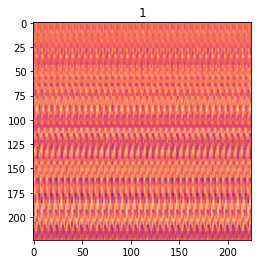

In [13]:
import matplotlib.pyplot as plt
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in trainloader:
    index = 5
    print(data.shape)
    img = data[index]
    print(img.shape)
    pic = ToPILImage(img)
    plt.title(int(target[index]))
    plt.imshow(pic)
    plt.show()
    break

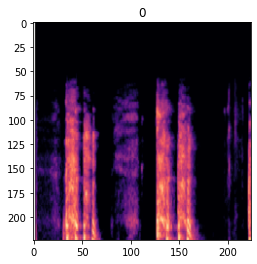

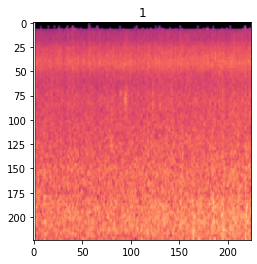

In [15]:
import matplotlib.pyplot as plt
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in trainloader:
    img = data[4]
    pic = ToPILImage(img)
    plt.title(int(target[4]))
    plt.imshow(pic)
    plt.show()
    img = data[2]
    pic = ToPILImage(img)
    plt.title(int(target[2]))
    plt.imshow(pic)
    plt.show()
    break

In [16]:
print(len(train[0]),len(valid[0]))

80 20


### Resnet

In [23]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [24]:
from torchvision.models import resnet50
model = resnet50(pretrained = False)

model.l1 = nn.Linear(2048, 256)
model.l2 = nn.Linear(256, 2)
nn.init.kaiming_normal_(model.l1.weight)
nn.init.kaiming_normal_(model.l2.weight)

model.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         model.l1,
                         nn.Dropout(0.5),
                         nn.BatchNorm1d(256),
                         model.l2,
                         nn.Dropout(0.5)
                         )

model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [25]:
n = 0
for data, target in train[0]:
    print(data.shape) # (batch, channel, width, height)
    break

data = data.to(device)

with torch.no_grad():
    y = model(data)
    print(y)
    print(np.argmax(y.cpu(), axis=1), target)

torch.Size([10, 3, 224, 224])
tensor([[-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [ 0.0000,  0.0000],
        [ 2.1223,  4.3599],
        [-1.2196, -0.0000],
        [-0.0000, -5.8061],
        [ 0.0000, -1.3645],
        [ 3.2357,  0.4927],
        [-0.3014, -0.0000],
        [-0.0000, 13.6871]], device='cuda:0')
tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1]) tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1])


In [26]:
num=[]
for _, test_target in valid[0]:
  num += test_target
print(sum(num))

tensor(95)


In [27]:
list_training_loss = []
list_test_loss = []

In [61]:
def training_model(n_epochs, last_epoch, trainloader, testloader, seed, device, lr=0.001):
  seed_everything(seed)
  optimizer = torch.optim.Adam(model.parameters(), lr)
  criterion = nn.CrossEntropyLoss().to(device)

  for epoch in range(n_epochs):
    n_train, train_loss = 0,0
    model.train()
    for train_data, train_target in trainloader:
      train_data, train_target = train_data.to(device), train_target.to(device)
      y = model(train_data)
      del train_data
      loss = criterion(y, train_target).sum()
      train_loss += loss.data.cpu().numpy()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      n_train += 1
      del train_target
    
    if (epoch % 4 == 0) | (epoch == n_epochs-1):
      model.eval()
      n_test, test_loss = 0, 0
      correct, total, num_non, pred_non, TP  = 0, 0, 0, 0, 0
      for test_data, test_target in testloader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred = model(test_data)
        idx_pred = torch.max(y_pred, 1)[1]
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1
        total += len(test_target)
        num_non += test_target.sum()
        pred_non += idx_pred.sum()
        correct += (idx_pred == test_target).sum()
        TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

      accuracy = torch.round(correct * 100 / total, decimals=7)
      recall = torch.round(TP * 100 / (total - num_non), decimals=7)
      precision = torch.round(TP * 100 / (total - pred_non), decimals=7)
      f1score = torch.round(2 *(precision*recall) / (precision + recall), decimals=7)
      print('epoch {}th training loss: {} test loss: {}, accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(
            epoch + last_epoch + 1, round(train_loss / n_train, 7), round(test_loss / n_test, 7), accuracy, precision, recall,f1score))
      list_training_loss.append(train_loss / n_train)
      list_test_loss.append(test_loss / n_test)

In [67]:
def test_score(model, testloader, device):
  model.eval()

  correct, total, num_non, pred_non, TP  = 0, 0, 0, 0, 0
  for test_data, test_target in testloader:
    test_data = test_data.to(device)
    test_target = test_target.to(device)
    y_pred = model(test_data)
    idx_pred = torch.max(y_pred, 1)[1]
    del test_data
    total += len(test_target)
    num_non += test_target.sum()
    pred_non += idx_pred.sum()
    correct += (idx_pred == test_target).sum()
    TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

  accuracy = correct * 100 / total
  recall = TP * 100 / (total - num_non)
  precision = TP * 100 / (total - pred_non)
  f1score = 2 *(precision*recall) / (precision + recall)
  print('accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(accuracy, precision, recall, f1score))

## 학습

**1. 첫번째 train/valid로 50회 학습**

In [29]:
training_model(50, 0, train[0], valid[0], 42, device, lr=0.001)

epoch 1th training loss: 0.9295470464974642 test loss: 0.49637268781661986, accuracy: 73.73737335205078, precision: 80.72289276123047, recall: 65.04854583740234, f1 score: 72.04301452636719
epoch 5th training loss: 0.5722582191228867 test loss: 0.669024059176445, accuracy: 72.22222137451172, precision: 82.43243408203125, recall: 59.22330093383789, f1 score: 68.92655944824219
epoch 9th training loss: 0.5839084485545755 test loss: 0.4311942867934704, accuracy: 78.78787994384766, precision: 84.26966094970703, recall: 72.81553649902344, f1 score: 78.125
epoch 13th training loss: 0.5833451870363205 test loss: 0.40451930090785027, accuracy: 82.82828521728516, precision: 82.24298858642578, recall: 85.4368896484375, f1 score: 83.80952453613281
epoch 17th training loss: 0.5488328846171499 test loss: 0.46678376942873, accuracy: 76.7676773071289, precision: 84.33734893798828, recall: 67.96116638183594, f1 score: 75.26881408691406
epoch 21th training loss: 0.4847865654155612 test loss: 0.374441131

1-50


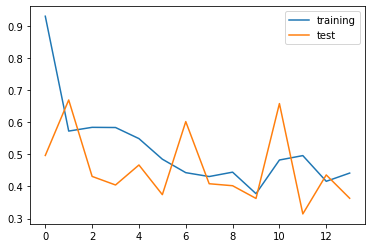

In [30]:
import matplotlib.pyplot as plt

print('1-50')
plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

**2. 두번째 train/valid로 50회 학습**

In [31]:
training_model(50, 50, train[1], valid[1], 14, device, lr=0.001)

epoch 51th training loss: 0.49033120069652797 test loss: 0.4179173305630684, accuracy: 82.32323455810547, precision: 89.13043212890625, recall: 76.63551330566406, f1 score: 82.41206359863281
epoch 55th training loss: 0.4515144843608141 test loss: 0.3595678459852934, accuracy: 88.38383483886719, precision: 86.84210205078125, recall: 92.52336120605469, f1 score: 89.59275817871094
epoch 59th training loss: 0.46266221031546595 test loss: 0.38575100153684616, accuracy: 85.3535385131836, precision: 82.5, recall: 92.52336120605469, f1 score: 87.22467041015625
epoch 63th training loss: 0.515993294864893 test loss: 0.38250909447669984, accuracy: 81.81818389892578, precision: 81.98197937011719, recall: 85.0467300415039, f1 score: 83.48623657226562
epoch 67th training loss: 0.46210533678531646 test loss: 0.4524096190929413, accuracy: 74.24242401123047, precision: 87.83783721923828, recall: 60.74766540527344, f1 score: 71.82319641113281
epoch 71th training loss: 0.4124262663535774 test loss: 0.378

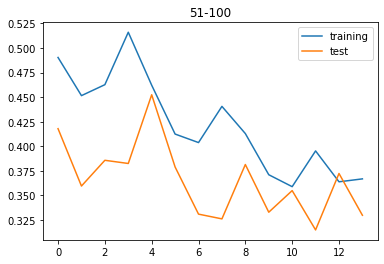

In [33]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[14:], label='training')
plt.plot(list_test_loss[14:], label='test')
plt.title('51-100')
plt.legend()
plt.show()

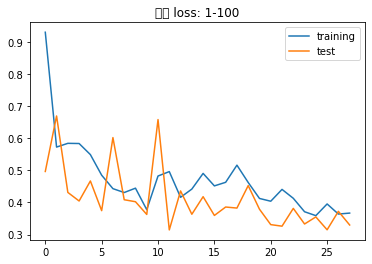

In [36]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('누적 loss: 1-100')
plt.legend()
plt.show()

epoch 100 시점의 test score 계산

In [34]:
# test score:

accuracy: 86.0, precision: 81.44329833984375, recall: 88.76404571533203, f1 score: 84.94624328613281


**3. 세번째 train/valid로 50회 학습**

In [37]:
training_model(50, 100, train[2], valid[2], 77, device, lr=0.001)

epoch 101th training loss: 0.4147084913216531 test loss: 0.21215896476060153, accuracy: 92.92929077148438, precision: 94.23076629638672, recall: 92.45282745361328, f1 score: 93.33332824707031
epoch 105th training loss: 0.43821731545031073 test loss: 0.2680590432137251, accuracy: 91.41413879394531, precision: 88.6956558227539, recall: 96.2264175415039, f1 score: 92.30769348144531
epoch 109th training loss: 0.3459382912144065 test loss: 0.2358517326414585, accuracy: 90.90908813476562, precision: 94.0, recall: 88.67924499511719, f1 score: 91.26213073730469
epoch 113th training loss: 0.34003526987507937 test loss: 0.24283489473164083, accuracy: 91.41413879394531, precision: 93.2038803100586, recall: 90.5660400390625, f1 score: 91.86602783203125
epoch 117th training loss: 0.37519167400896547 test loss: 0.24219621270895003, accuracy: 89.89898681640625, precision: 89.81481170654297, recall: 91.50943756103516, f1 score: 90.65421295166016
epoch 121th training loss: 0.2948556512274081 test loss:

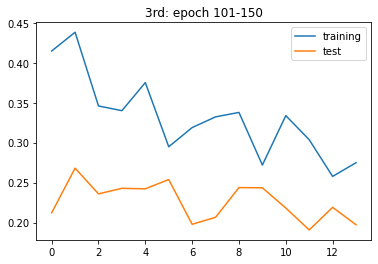

In [41]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[28:], label='training')
plt.plot(list_test_loss[28:], label='test')
plt.title('3rd: epoch 101-150')
plt.legend()
plt.show()

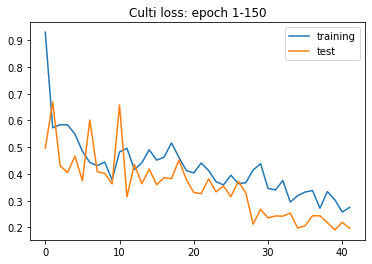

In [42]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-150')
plt.legend()
plt.show()

epoch 150 시점의 test score 계산

In [40]:
# test score:

accuracy: 87.0, precision: 83.87096405029297, recall: 87.64044952392578, f1 score: 85.71427917480469


**4. 네번째 train/valid로 50회 학습**

In [43]:
training_model(50, 150, train[3], valid[3], 256, device, lr=0.001)

epoch 151th training loss: 0.3643619359849254 test loss: 0.09877277743071318, accuracy: 98.48484802246094, precision: 100.0, recall: 97.02970123291016, f1 score: 98.49246215820312
epoch 155th training loss: 0.32030877729412166 test loss: 0.1592552935704589, accuracy: 93.93939208984375, precision: 96.84210205078125, recall: 91.089111328125, f1 score: 93.87754821777344
epoch 159th training loss: 0.27390723591670396 test loss: 0.11030104819219559, accuracy: 96.96969604492188, precision: 96.11650848388672, recall: 98.0197982788086, f1 score: 97.05882263183594
epoch 163th training loss: 0.2857295981608331 test loss: 0.17816622257232667, accuracy: 94.94949340820312, precision: 93.33333587646484, recall: 97.02970123291016, f1 score: 95.1456298828125
epoch 167th training loss: 0.23251015008427203 test loss: 0.08732637814246118, accuracy: 97.47474670410156, precision: 98.9795913696289, recall: 96.03960418701172, f1 score: 97.48744201660156
epoch 171th training loss: 0.2871493016951717 test loss

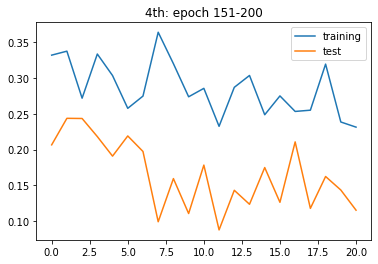

In [46]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[35:], label='training')
plt.plot(list_test_loss[35:], label='test')
plt.title('4th: epoch 151-200')
plt.legend()
plt.show()

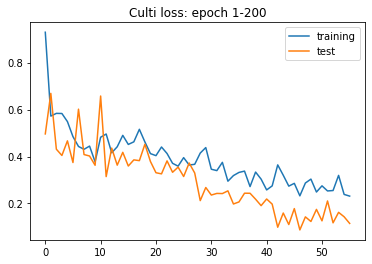

In [47]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-200')
plt.legend()
plt.show()

epoch 200 시점의 test score 계산

In [48]:
#test score:

accuracy: 84.5, precision: 77.35848999023438, recall: 92.13483428955078, f1 score: 84.10256958007812


In [39]:
torch.save(model, 'model_cough200.pt') 

**5. 다섯번째 train/valid로 50회 학습**

In [62]:
training_model(50, 200, train[4], valid[4], 122, device, lr=0.001)

epoch 201th training loss: 0.28366 test loss: 0.06878, accuracy: 97.0, precision: 96.73912811279297, recall: 96.73912811279297, f1 score: 96.73912811279297
epoch 205th training loss: 0.26809 test loss: 0.08716, accuracy: 97.0, precision: 93.87754821777344, recall: 100.0, f1 score: 96.84210205078125
epoch 209th training loss: 0.24373 test loss: 0.08259, accuracy: 97.0, precision: 97.77777862548828, recall: 95.65218353271484, f1 score: 96.70329284667969
epoch 213th training loss: 0.2355 test loss: 0.10974, accuracy: 96.0, precision: 95.65218353271484, recall: 95.65218353271484, f1 score: 95.65218353271484
epoch 217th training loss: 0.24568 test loss: 0.1084, accuracy: 96.0, precision: 96.66665649414062, recall: 94.56522369384766, f1 score: 95.6043930053711
epoch 221th training loss: 0.24107 test loss: 0.11979, accuracy: 95.0, precision: 93.61701965332031, recall: 95.65218353271484, f1 score: 94.6236572265625
epoch 225th training loss: 0.2879 test loss: 0.1247, accuracy: 96.0, precision: 

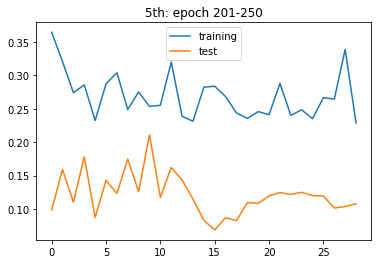

In [63]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[42:], label='training')
plt.plot(list_test_loss[42:], label='test')
plt.title('5th: epoch 201-250')
plt.legend()
plt.show()

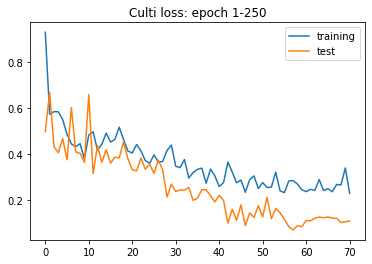

In [64]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.title('Culti loss: epoch 1-250')
plt.legend()
plt.show()

In [68]:
# 최종 test score
test_score(model, testloader, device)

accuracy: 87.5, precision: 84.78260803222656, recall: 87.64044952392578, f1 score: 86.1878433227539


In [69]:
torch.save(model, 'model_cough250.pt') 